## 使用LightGBM进行分类预测

### 1.导入库

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split # 划分数据集
from sklearn.ensemble import RandomForestClassifier  # 随机森林
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV  # 网格划分
from sklearn.metrics import accuracy_score,recall_score,log_loss # 模型评估
import joblib # 模型保存

### 2.读取数据与预处理

In [34]:
data = pd.read_csv('openpose_train_data.csv')
data

,Unnamed: 0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,a9,a10,a11,a12,a13,a14,a15,a16,a17,label
0,img_100026.jpg,127.137721,24.738634,18.973666,61.773781,NaN,64.621978,157.035028,142.618372,63.780875,...,-4.055314,NaN,3.185424,0.382155,1.004067,-1.479100,-2.483167,2.341270,2.019520,0
1,img_10003.jpg,80.049984,18.973666,26.832816,53.665631,NaN,50.911688,133.221620,118.186294,50.911688,...,-4.414870,NaN,3.700192,0.558599,0.785398,-1.665748,-2.451146,2.502383,2.199050,0
2,img_100050.jpg,96.932967,18.973666,NaN,43.266615,NaN,46.861498,164.754363,151.789328,50.911688,...,-3.937187,NaN,3.455825,0.404892,NaN,-1.512041,NaN,2.211233,1.911945,0
3,img_100074.jpg,108.166538,37.947332,30.594117,64.899923,NaN,59.093147,197.362610,174.000000,48.373546,...,-4.416948,NaN,3.504318,0.463648,1.051650,-1.837048,-2.888699,2.485020,2.300696,0
4,img_10012.jpg,84.214013,24.738634,18.000000,53.665631,NaN,51.613952,163.768129,189.736660,51.613952,...,NaN,NaN,3.690535,0.548942,-4.957368,-1.744468,3.212900,2.441489,2.137809,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22391,5.jpg,98.407317,21.633308,18.973666,54.332311,NaN,43.680659,115.412304,122.376468,56.920998,...,-4.449394,NaN,3.778394,0.593350,-4.978641,-1.503103,3.475538,2.120696,1.842396,2
22392,6.jpg,89.196412,25.455844,18.973666,54.000000,NaN,48.000000,114.629839,131.726990,54.000000,...,-4.468285,NaN,3.879408,0.737815,-5.176037,-1.523213,3.652823,1.986861,1.659616,2
22393,7.jpg,101.823376,25.455844,30.000000,48.373546,NaN,37.947332,121.490740,128.825463,43.680659,...,-4.251517,NaN,3.605240,0.507099,-5.497787,-1.570796,3.926991,2.000559,1.668523,2
22394,8.jpg,80.721744,21.633308,21.633308,48.373546,NaN,48.373546,114.000000,134.164079,54.000000,...,-4.156744,NaN,3.855219,0.837981,-4.712389,-1.425984,3.286405,2.095157,1.738256,2


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22396 entries, 0 to 22395
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  22396 non-null  object 
 1   d1          22169 non-null  float64
 2   d2          22059 non-null  float64
 3   d3          19920 non-null  float64
 4   d4          21651 non-null  float64
 5   d5          2643 non-null   float64
 6   d6          22349 non-null  float64
 7   d7          21747 non-null  float64
 8   d8          19946 non-null  float64
 9   d9          22345 non-null  float64
 10  d10         21391 non-null  float64
 11  d11         20228 non-null  float64
 12  d12         21356 non-null  float64
 13  d13         19525 non-null  float64
 14  d14         4759 non-null   float64
 15  d15         21668 non-null  float64
 16  d16         18118 non-null  float64
 17  d17         1804 non-null   float64
 18  a1          21651 non-null  float64
 19  a2          2643 non-null

#### 删除缺失值过多的列

In [36]:
for l in data.columns:
    if data[l].count() < 5000:
        data = data.drop([l], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22396 entries, 0 to 22395
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  22396 non-null  object 
 1   d1          22169 non-null  float64
 2   d2          22059 non-null  float64
 3   d3          19920 non-null  float64
 4   d4          21651 non-null  float64
 5   d6          22349 non-null  float64
 6   d7          21747 non-null  float64
 7   d8          19946 non-null  float64
 8   d9          22345 non-null  float64
 9   d10         21391 non-null  float64
 10  d11         20228 non-null  float64
 11  d12         21356 non-null  float64
 12  d13         19525 non-null  float64
 13  d15         21668 non-null  float64
 14  d16         18118 non-null  float64
 15  a1          21651 non-null  float64
 16  a3          21742 non-null  float64
 17  a4          19946 non-null  float64
 18  a5          21381 non-null  float64
 19  a6          20228 non-nul

#### 缺失值进行同类均值补充

In [37]:
for l in data['label'].value_counts().index:
    mean_val = data[data.label==l].mean()
    data[data.label==l] = data[data.label==l].fillna(mean_val)
data.head()

,Unnamed: 0,d1,d2,d3,d4,d6,d7,d8,d9,d10,...,a7,a9,a11,a12,a13,a14,a15,a16,a17,label
0,img_100026.jpg,127.137721,24.738634,18.973666,61.773781,64.621978,157.035028,142.618372,63.780875,120.149906,...,-4.369365,-4.055314,3.185424,0.382155,1.004067,-1.479100,-2.483167,2.341270,2.019520,0
1,img_10003.jpg,80.049984,18.973666,26.832816,53.665631,50.911688,133.221620,118.186294,50.911688,93.145048,...,-4.515336,-4.414870,3.700192,0.558599,0.785398,-1.665748,-2.451146,2.502383,2.199050,0
2,img_100050.jpg,96.932967,18.973666,22.044608,43.266615,46.861498,164.754363,151.789328,50.911688,97.672924,...,-4.384618,-3.937187,3.455825,0.404892,0.245618,-1.512041,-1.826560,2.211233,1.911945,0
3,img_100074.jpg,108.166538,37.947332,30.594117,64.899923,59.093147,197.362610,174.000000,48.373546,109.489726,...,-4.540093,-4.416948,3.504318,0.463648,1.051650,-1.837048,-2.888699,2.485020,2.300696,0
4,img_10012.jpg,84.214013,24.738634,18.000000,53.665631,51.613952,163.768129,189.736660,51.613952,124.851912,...,-4.233964,-4.083615,3.690535,0.548942,-4.957368,-1.744468,3.212900,2.441489,2.137809,0


#### 处理第一列名称

In [38]:
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,d1,d2,d3,d4,d6,d7,d8,d9,d10,d11,...,a7,a9,a11,a12,a13,a14,a15,a16,a17,label
0,127.137721,24.738634,18.973666,61.773781,64.621978,157.035028,142.618372,63.780875,120.149906,108.664622,...,-4.369365,-4.055314,3.185424,0.382155,1.004067,-1.479100,-2.483167,2.341270,2.019520,0
1,80.049984,18.973666,26.832816,53.665631,50.911688,133.221620,118.186294,50.911688,93.145048,84.000000,...,-4.515336,-4.414870,3.700192,0.558599,0.785398,-1.665748,-2.451146,2.502383,2.199050,0
2,96.932967,18.973666,22.044608,43.266615,46.861498,164.754363,151.789328,50.911688,97.672924,72.993150,...,-4.384618,-3.937187,3.455825,0.404892,0.245618,-1.512041,-1.826560,2.211233,1.911945,0
3,108.166538,37.947332,30.594117,64.899923,59.093147,197.362610,174.000000,48.373546,109.489726,116.498927,...,-4.540093,-4.416948,3.504318,0.463648,1.051650,-1.837048,-2.888699,2.485020,2.300696,0
4,84.214013,24.738634,18.000000,53.665631,51.613952,163.768129,189.736660,51.613952,124.851912,117.204537,...,-4.233964,-4.083615,3.690535,0.548942,-4.957368,-1.744468,3.212900,2.441489,2.137809,0


### 3.切分数据输入（特征）与输出（预测目标变量）

In [39]:
label = data.label
feature = data.drop(['label'], axis=1)

### 4.切分训练集与测试集（0.8：0.2）

In [43]:
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.00000001)

### 5.模型训练

In [44]:
RFC = RandomForestClassifier(n_estimators=50, random_state=0)
RFC.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=0)

### 6.模型的存储与加载

In [45]:
# 模型存储
joblib.dump(RFC, 'RandomForestClassifier_model.pkl')
# 模型加载
RFC = joblib.load('RandomForestClassifier_model.pkl')

### 7.模型的预测与评估

In [42]:
# 模型预测
y_pred = RFC.predict(X_test)
y_pred_proba = RFC.predict_proba(X_test)

# 模型评估
print('正确率:', accuracy_score(y_test, y_pred))
print("损失值:", log_loss(y_test, y_pred_proba))

正确率: 0.9392748705125915
损失值: 0.3425187971418098


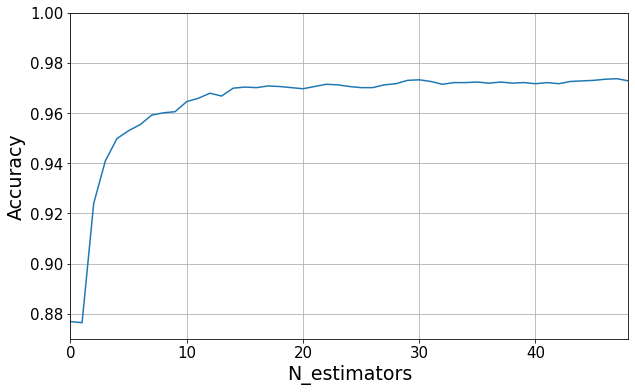

In [61]:
import matplotlib.pyplot as plt
accuracy=[]
for i in range(1,50):
    RFC = RandomForestClassifier(n_estimators=i, random_state=0)
    RFC.fit(X_train, y_train)
    y_pred = RFC.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
plt.figure(figsize=(10,6))
plt.plot(accuracy)
plt.ylabel('Accuracy',fontsize=19)
plt.xlabel('N_estimators',fontsize=19)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0.87,1])
plt.xlim([0,48])
plt.grid()

In [57]:
    from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, classification_report, accuracy_score
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    print("Precision is ", round(precision,4))
    print("Recall is ", round(recall,4))
    print("f1 score is ", round(f1,4))
    print("accuracy score is ", round(acc,4))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       518
           1       0.97      1.00      0.98       454
           2       0.97      0.99      0.98       474
           3       0.98      0.98      0.98       451
           4       0.99      0.99      0.99       446
           5       0.99      0.98      0.99       459
           6       0.98      0.97      0.97       500
           7       1.00      0.99      0.99       399
           8       0.97      0.90      0.94       378
           9       0.96      0.94      0.95       397

    accuracy                           0.97      4476
   macro avg       0.97      0.97      0.97      4476
weighted avg       0.97      0.97      0.97      4476

Precision is  0.9738
Recall is  0.9736
f1 score is  0.9735
accuracy score is  0.9736
